In [64]:
import cv2
import os

In [65]:
import numpy as np
import matplotlib.pyplot as plt

## Pre-processing

In [66]:
def grayScaleConversion(path):
    dict1 = {}
    dict2 = {}
    classes = os.listdir(path)
    for classe in classes:
        pathFile = path + '/' + classe
        images = os.listdir(pathFile)
        for i in range(len(images)):
            img = cv2.imread(pathFile +'/' + images[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            R, G, B = img[:,:,0], img[:,:,1],img[:,:,2]
            imgGray = 0.299 * R + 0.587 * G + 0.114 * B
            if classe == 'benign':
                dict1[pathFile+ '/' + images[i]] = imgGray
            else:
                dict2[pathFile+ '/' + images[i]] = imgGray       
    return dict1,dict2        

In [67]:
def noiseRemoval(dict1, dict2):
    for key,value in dict1.items() :
        newimg = cv2.medianBlur(value, 1)
        dict1[key] = newimg
    for key,value in dict2.items() :
        newimg = cv2.medianBlur(value, 1)
        dict2[key] = newimg 
    return dict1, dict2

In [68]:
def imageEnhancement(dict1, dict2):
    for key,value in dict1.items() :
        value = np.uint8(cv2.normalize(value, None, 0, 255, cv2.NORM_MINMAX))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        #gray_img_eqhist=cv2.equalizeHist(value)
        value=clahe.apply(value)
        dict1[key] = value
    for key,value in dict2.items() :
        value = np.uint8(cv2.normalize(value, None, 0, 255, cv2.NORM_MINMAX))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        #gray_img_eqhist=cv2.equalizeHist(value)
        value=clahe.apply(value)
        dict2[key] = value
    return dict1, dict2

In [69]:
path_train = 'data/train'

In [70]:
images = os.listdir(path_train)
print(images)
for i in images:
    print (i)

['benign', 'malignant']
benign
malignant


In [71]:
dict1, dict2 = grayScaleConversion(path_train)

In [72]:
len(dict1)

1440

In [73]:
img1= dict1['data/train/benign/1189.jpg']

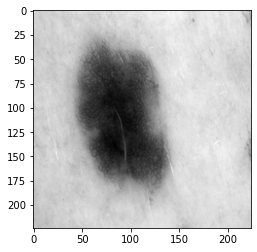

In [74]:
plt.imshow(img1, cmap='gray')

In [75]:
dict1, dict2 = noiseRemoval(dict1, dict2)

In [76]:
dict1

{'data/train/benign/100.jpg': array([[191.105, 192.008, 192.236, ..., 172.63 , 169.63 , 169.103],
        [188.8  , 190.849, 188.333, ..., 169.103, 171.63 , 173.325],
        [190.817, 193.86 , 190.105, ..., 172.63 , 174.146, 172.63 ],
        ...,
        [165.27 , 169.096, 166.965, ..., 158.793, 162.135, 163.531],
        [163.993, 165.993, 165.737, ..., 158.787, 163.836, 164.531],
        [163.993, 164.047, 164.737, ..., 156.195, 158.776, 161.531]]),
 'data/train/benign/1000.jpg': array([[148.99 , 149.762, 150.762, ..., 148.213, 150.68 , 147.919],
        [150.235, 147.762, 149.958, ..., 149.968, 150.136, 149.196],
        [147.702, 148.99 , 148.958, ..., 154.261, 150.147, 147.826],
        ...,
        [131.957, 132.729, 136.946, ..., 142.017, 140.963, 140.322],
        [128.245, 130.017, 131.74 , ..., 138.322, 135.202, 136.262],
        [129.729, 133.017, 132.985, ..., 136.034, 134.806, 137.877]]),
 'data/train/benign/1001.jpg': array([[153.886, 155.163, 160.864, ..., 147.163, 150

In [77]:
img2  = dict1['data/train/benign/1189.jpg']

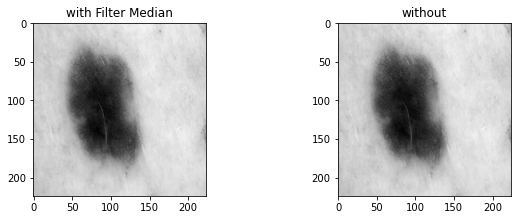

In [78]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.title("with Filter Median")
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 2, 2)
plt.title("without")
plt.imshow(img1, cmap='gray')

In [79]:
dict1, dict2 = imageEnhancement(dict1, dict2)

In [80]:
img3  = dict1['data/train/benign/1189.jpg']

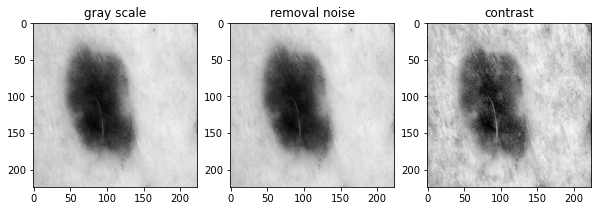

In [81]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 3, 1)
plt.title("gray scale")
plt.imshow(img1, cmap='gray')
fig.add_subplot(2, 3, 2)
plt.title("removal noise")
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 3, 3)
plt.title("contrast")
plt.imshow(img3, cmap='gray')

## Segmentation

In [82]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import threshold_otsu

In [83]:
def segment(img):
    """
    Maximum entropy segmentation
    :param img:
    :return:
    """
    def calculate_current_entropy(hist, threshold):
        data_hist = hist.copy()
        background_sum = 0.
        target_sum = 0.
        for i in range(256):
            if i < threshold:  #
                background_sum += data_hist[i]
            else:  #
                target_sum += data_hist[i]
        background_ent = 0.
        target_ent = 0.
        for i in range(256):
            if i < threshold:  # Calculate background entropy
                if data_hist[i] == 0:
                    continue
                ratio1 = data_hist[i] / background_sum
                background_ent -= ratio1 * np.log2(ratio1)
            else:
                if data_hist[i] == 0:
                    continue
                ratio2 = data_hist[i] / target_sum
                target_ent -= ratio2 * np.log2(ratio2)
        return target_ent + background_ent
    def max_entropy_segmentation(img):
            channels = [0]
            hist_size = [256]
            prange = [0, 256]
            hist = cv2.calcHist(img, channels, None, hist_size, prange)
            hist = np.reshape(hist, [-1])
            max_ent = 0.
            max_index = 0
            for i in range(256):
                cur_ent = calculate_current_entropy(hist, i)
                if cur_ent > max_ent:
                    max_ent = cur_ent
                    max_index = i
            ret, th = cv2.threshold(img, max_index, 255, cv2.THRESH_BINARY)
            return th
    img = max_entropy_segmentation(img)
    return img

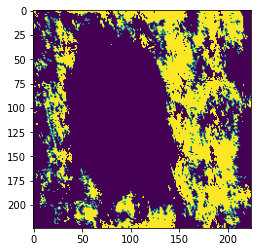

In [84]:
plt.imshow(segment(img3))

In [85]:
def segmentation(dict1, dict2):
    i=0
    for key,value in dict1.items() :
        newValue = segment(value)
        dict1[key] = newValue
        print(i)
        i+=1
    i=0
    for key, value in dict2.items():
        newValue = segment(value)
        dict2[key] = newValue
        print(i)
        i+=1
    return dict1, dict2    

In [ ]:
print("start")
dict1, dict2 = segmentation(dict1, dict2)
print("end")

start
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [ ]:
img4 = dict1['data/train/benign/1189.jpg']

In [ ]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 4, 1)
plt.title("gray scale")
plt.imshow(img1, cmap='gray')
fig.add_subplot(2, 4, 2)
plt.title("removal noise")
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 4, 3)
plt.title("contraste")
plt.imshow(img3, cmap='gray')
fig.add_subplot(2, 4, 4)
plt.title("image segmented")
plt.imshow(img4, cmap='gray')

## Features Extraction

### GLCM ( gray-level co-occurrence matrix )

In [ ]:
import pandas as pd
import matplotlib.pyplot as pltHomogeneity
from skimage.feature import greycomatrix, greycoprops

In [ ]:
def GLCM(img):
    GLCM = greycomatrix(img,[1],[0,np.pi/4,np.pi/2,3*np.pi/4])
    Contrast = greycoprops(GLCM,'contrast')[0,0]
    ASM = greycoprops(GLCM,'ASM')[0,0]
    Energy = greycoprops(GLCM,'energy')[0,0]
    Homogeneity = greycoprops(GLCM,'homogeneity')[0,0]
    correlation = greycoprops(GLCM,'correlation')[0,0]
    return Contrast, ASM, Energy, Homogeneity, correlation

In [ ]:
Contrast, ASM, Energy, Homogeneity, correlation = GLCM(img4)

In [ ]:
Contrast

In [ ]:
ASM

In [ ]:
Energy

In [ ]:
correlation

In [ ]:
Homogeneity

In [ ]:
def featuresExtraction(dict1, dict2):
    df=pd.DataFrame(columns=['Contrast','ASM','Energy','Homogeneity','correlation','outcome'])
    i=0
    for key, value in dict1.items():
        Contrast, ASM, Energy, Homogeneity, correlation = GLCM(value)
        df.loc[len(df.index)] = [Contrast, ASM, Energy, Homogeneity, correlation, 'begnin']
        print(i)
        i+=1
    for key, value in dict2.items():
        i=0
        Contrast, ASM, Energy, Homogeneity, correlation = GLCM(value)
        df.loc[len(df.index)] = [Contrast, ASM, Energy, Homogeneity, correlation, 'malignant']
        print(i)
        i+=1
    return df  

In [ ]:
df = featuresExtraction(dict1, dict2)

In [ ]:
df.shape

In [ ]:
df.tail(20)

In [ ]:
df.to_csv('features_train_KC.csv')

## Classification

In [ ]:
from sklearn.svm import SVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
y = df['outcome'].map({"begnin":0,"malignant":1})

In [ ]:
y

In [ ]:
df = df.drop(['outcome'], axis=1)

In [ ]:
x = df

In [ ]:
x

In [ ]:
svclassifier = SVC(kernel = 'rbf')
model = svclassifier.fit(x, y)

In [ ]:
LSVM = LinearSVC(penalty='l1', loss='squared_hinge', C=1.0, dual=False)
model2 = LSVM.fit(x, y)

## Test data

In [ ]:
path_test = 'data/test'

## Pre-processing

In [ ]:
dict_test1, dict_test2 = grayScaleConversion(path_test)

In [ ]:
dict_test1, dict_test2 = noiseRemoval(dict_test1, dict_test2)

In [ ]:
dict_test1, dict_test2 = imageEnhancement(dict_test1, dict_test2)

## Sigmentation

In [ ]:
dict_test1, dict_test2 = segmentation(dict_test1, dict_test2)

## Features Extraction

In [ ]:
df_test = featuresExtraction(dict_test1, dict_test2)

In [ ]:
df_test.head(20)

In [ ]:
df_test.tail(20)

In [ ]:
df_test.to_csv('features_test_KC.csv')

## Prediction

In [ ]:
y_test = df_test['outcome'].map({"begnin":0,"malignant":1})
df_test = df_test.drop(['outcome'], axis=1)
x_test =  df_test

In [ ]:
y_predict = model2.predict(x_test)

In [ ]:
y_predict

In [ ]:
y_test = np.asarray(y_test)
y_test

In [ ]:
accuracy = model2.score(x_test,y_test)

In [ ]:
accuracy